## First, load the data

To begin, load up some data from a database into a DataFrame.

In [ ]:
# To keep the page organized, do all imports here
from sqlalchemy import create_engine
import pandas as pd
from scipy import stats


In [ ]:
# Database credentials
postgres_user = 'dabc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'kickstarterprojects'

# Use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [ ]:
projects_df = pd.read_sql_table('ksprojects', con=engine)

# Remove the connection
engine.dispose()

Now, quickly examine your DataFrame.

In [ ]:
projects_df.shape

(65418, 13)

In [ ]:
projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65418 entries, 0 to 65417
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             65418 non-null  int64         
 1   name           65418 non-null  object        
 2   category       65418 non-null  object        
 3   main_category  65418 non-null  object        
 4   deadline       65418 non-null  datetime64[ns]
 5   goal           65418 non-null  float64       
 6   launched       65418 non-null  datetime64[ns]
 7   state          65418 non-null  object        
 8   backers        65418 non-null  int64         
 9   country        65418 non-null  object        
 10  usd_pledged    64673 non-null  float64       
 11  currency       65418 non-null  object        
 12  pledged        65418 non-null  float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(6)
memory usage: 6.5+ MB


You can see that there are several numeric columns and a couple of date columns. There's also some categorical data. Most importantly, though, there are no nulls in any columns except *usd_pledged*. Notice that each column has 65,418 values, except *usd_pledged*, which has 64,673 values. If you are going to use that column in your analysis, you'll need to deal with those nulls.  



In [ ]:
projects_df.head()

,id,name,category,main_category,deadline,goal,launched,state,backers,country,usd_pledged,currency,pledged
0,1147015301,"""All We Had"" Gets Into Cannes -- $10 or More G...",Documentary,Film & Video,2009-05-20 21:50:00,300.0,2009-04-30 22:10:30,failed,4,US,40.00,USD,40.00
1,1100844465,daily digest,Documentary,Film & Video,2009-06-01 02:20:00,700.0,2009-05-04 21:14:28,successful,14,US,700.00,USD,700.00
2,1316334968,Drive A Faster Car 2.0,Nonfiction,Publishing,2009-06-04 06:00:00,1000.0,2009-05-04 22:51:31,successful,32,US,1367.00,USD,1367.00
3,1304906577,Accidental to Edinburgh - PHASE 1: AIRFARE,Theater,Theater,2009-06-05 05:59:00,6000.0,2009-04-30 22:22:43,successful,24,US,6575.00,USD,6575.00
4,1099226462,Logical Guess Pictures' 2nd Horror Movie!,Film & Video,Film & Video,2009-06-06 00:45:00,500.0,2009-04-30 01:32:55,successful,22,US,501.66,USD,501.66


Before you move on, it would be interesting to find out how many different categories exist. There are a few ways to do this.

In [ ]:
# Count the number of unique values in this column
projects_df['category'].nunique()

158

In [ ]:
# Find the frequency of each value in the column
category_counts = projects_df['category'].value_counts()

# Only print the first 10, because 158 is too many to print
category_counts.head(10)

Product Design    3444
Documentary       2969
Music             2740
Shorts            2407
Tabletop Games    2208
Food              2126
Video Games       2011
Film & Video      1828
Fiction           1670
Fashion           1584
Name: category, dtype: int64

Do the same for the *main_category* column.

In [ ]:
projects_df['main_category'].nunique()

15

In [ ]:
main_category_counts = projects_df['main_category'].value_counts()

# There are only 15 main categories, so print them all.
main_category_counts

Film & Video    11666
Music            9395
Publishing       6901
Games            5739
Technology       5328
Art              4843
Design           4798
Food             4343
Fashion          3700
Theater          2015
Photography      1933
Comics           1791
Crafts           1474
Journalism        811
Dance             681
Name: main_category, dtype: int64

The *state*, *currency*, and *country* columns also look like they have categorical data. See if there's anything interesting going on there.

In [ ]:
# How many countries?
projects_df['country'].nunique()

22

In [ ]:
# How are the projects distributed over the countries?
country_counts = projects_df['country'].value_counts()
country_counts

US      52071
GB       5617
CA       2404
AU       1258
N,"0      744
DE        538
NL        457
FR        397
IT        374
ES        294
SE        267
NZ        236
DK        157
NO        120
IE         99
AT         98
BE         90
CH         88
MX         43
SG         29
HK         26
LU         11
Name: country, dtype: int64

So although the majority of projects are from the US, there are many other countries represented. Now, examine the currency.

In [ ]:
projects_df['currency'].nunique()

13

In [ ]:
currency_counts = projects_df['currency'].value_counts()
currency_counts

USD    52597
GBP     5722
CAD     2445
EUR     2399
AUD     1271
SEK      271
NZD      241
DKK      163
NOK      123
CHF       88
MXN       43
SGD       29
HKD       26
Name: currency, dtype: int64

As expected, most projects use US dollars. However, many others use a different currency. This is an important discovery. Before you do any sort of analysis on money, you need to ensure that you are working with the same currency. Trying to find the mean would be meaningless if the amounts are in different currencies. The *usd_pledged* column is the amount of money pledged converted to USD, but the *pledged* and *goal* columns are in the specified currency. Before you solve that problem, see how many different states are in the *state* column.


In [ ]:
projects_df['state'].nunique()

6

In [ ]:
state_counts = projects_df['state'].value_counts()
state_counts

failed        33922
successful    23125
canceled       6427
live            938
undefined       695
suspended       311
Name: state, dtype: int64

## Handling nulls

Earlier, you saw that one of the columns has some null values. If that column is significant to your analysis, then you need to do something about those null values. There are several options:

 - Set a default value
 - Try to "guess" an appropriate value
 - Delete the rows altogether
 
Of course, the choice depends on the data and the type of analysis that you wish to perform. In this example, the nulls occur in the *usd_pledged* column. It might help if you looked at those rows to see what that data looks like.
 
The pandas library has a built-in `isnull()` method to help find nulls across all columns in the DataFrame.

In [ ]:
null_rows = projects_df[projects_df.isnull().any(axis=1)]
null_rows.head(10)

,id,name,category,main_category,deadline,goal,launched,state,backers,country,usd_pledged,currency,pledged
9490,1189637889,"""Natural Born Hooker""",Theater,Theater,2012-04-24 08:59:00,25000.0,2012-03-14 19:05:44,undefined,0,"N,""0",NaN,USD,2621.00
15111,1244477824,Statpedia - The Collaborative Search Engine fo...,Software,Technology,2012-12-14 10:48:14,500.0,2012-11-14 10:48:14,undefined,0,"N,""0",NaN,USD,500.00
17484,1084993156,"Willy Tea, Chris Doud and Chums: The Children'...",Music,Music,2013-04-09 06:06:11,3750.0,2013-03-26 05:06:11,successful,0,"N,""0",NaN,USD,4593.00
17532,1379649454,"Juiette Z. Payne presents debut EP ""Eternal Da...",Music,Music,2013-04-11 15:50:25,5000.0,2013-03-02 15:50:25,successful,0,"N,""0",NaN,USD,5250.00
27334,1349042579,O'Films Production Launch!,Film & Video,Film & Video,2014-04-30 02:58:25,6000.0,2014-04-08 02:58:25,undefined,0,"N,""0",NaN,USD,6168.00
27443,1205956740,"Short Film - ""The Man Who Choked""",Film & Video,Film & Video,2014-05-02 12:47:00,1000.0,2014-04-16 13:21:21,undefined,0,"N,""0",NaN,GBP,1042.00
27522,1125500286,All About Amy,Film & Video,Film & Video,2014-05-04 17:41:13,3000.0,2014-04-04 17:41:13,undefined,0,"N,""0",NaN,USD,3225.00
27574,1292835145,WonderQuest ~ A Feature Length Music Film,Film & Video,Film & Video,2014-05-06 05:12:41,1111.0,2014-04-05 05:12:41,undefined,0,"N,""0",NaN,USD,3032.88
27602,1092574678,Pixelate Film Festival 2014,Film & Video,Film & Video,2014-05-07 13:37:16,1500.0,2014-04-09 13:37:16,undefined,0,"N,""0",NaN,GBP,1552.00
27755,1061706792,Zombie Shuffle feature film,Film & Video,Film & Video,2014-05-12 05:59:00,5000.0,2014-04-09 16:12:49,undefined,0,"N,""0",NaN,USD,5305.00


In [ ]:
null_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745 entries, 9490 to 59365
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             745 non-null    int64         
 1   name           745 non-null    object        
 2   category       745 non-null    object        
 3   main_category  745 non-null    object        
 4   deadline       745 non-null    datetime64[ns]
 5   goal           745 non-null    float64       
 6   launched       745 non-null    datetime64[ns]
 7   state          745 non-null    object        
 8   backers        745 non-null    int64         
 9   country        745 non-null    object        
 10  usd_pledged    0 non-null      float64       
 11  currency       745 non-null    object        
 12  pledged        745 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(2), object(6)
memory usage: 81.5+ KB


In a real-life situation, you may be able to go back to the source of this data and find out why the data is like this. For example, the *country* column appears to be broken, even though it contains a value. And the state seems to be undefined for many of these rows. There are only 745 problem rows, so it may be better for your analysis if you dropped those rows altogether.

If you choose to place a default value in these columns, you could use the `fillna()` method to replace all `NaN` values with a specific value. For example, to replace all `NaN` values with `0`, you could run the following code:

In [ ]:
zero_filled = null_rows.fillna(0)
zero_filled.head(10)

,id,name,category,main_category,deadline,goal,launched,state,backers,country,usd_pledged,currency,pledged
9490,1189637889,"""Natural Born Hooker""",Theater,Theater,2012-04-24 08:59:00,25000.0,2012-03-14 19:05:44,undefined,0,"N,""0",0.0,USD,2621.00
15111,1244477824,Statpedia - The Collaborative Search Engine fo...,Software,Technology,2012-12-14 10:48:14,500.0,2012-11-14 10:48:14,undefined,0,"N,""0",0.0,USD,500.00
17484,1084993156,"Willy Tea, Chris Doud and Chums: The Children'...",Music,Music,2013-04-09 06:06:11,3750.0,2013-03-26 05:06:11,successful,0,"N,""0",0.0,USD,4593.00
17532,1379649454,"Juiette Z. Payne presents debut EP ""Eternal Da...",Music,Music,2013-04-11 15:50:25,5000.0,2013-03-02 15:50:25,successful,0,"N,""0",0.0,USD,5250.00
27334,1349042579,O'Films Production Launch!,Film & Video,Film & Video,2014-04-30 02:58:25,6000.0,2014-04-08 02:58:25,undefined,0,"N,""0",0.0,USD,6168.00
27443,1205956740,"Short Film - ""The Man Who Choked""",Film & Video,Film & Video,2014-05-02 12:47:00,1000.0,2014-04-16 13:21:21,undefined,0,"N,""0",0.0,GBP,1042.00
27522,1125500286,All About Amy,Film & Video,Film & Video,2014-05-04 17:41:13,3000.0,2014-04-04 17:41:13,undefined,0,"N,""0",0.0,USD,3225.00
27574,1292835145,WonderQuest ~ A Feature Length Music Film,Film & Video,Film & Video,2014-05-06 05:12:41,1111.0,2014-04-05 05:12:41,undefined,0,"N,""0",0.0,USD,3032.88
27602,1092574678,Pixelate Film Festival 2014,Film & Video,Film & Video,2014-05-07 13:37:16,1500.0,2014-04-09 13:37:16,undefined,0,"N,""0",0.0,GBP,1552.00
27755,1061706792,Zombie Shuffle feature film,Film & Video,Film & Video,2014-05-12 05:59:00,5000.0,2014-04-09 16:12:49,undefined,0,"N,""0",0.0,USD,5305.00


But in this case, you would prefer to drop all the rows with `NaN`. So instead, use the `dropna()` method.

In [ ]:
# Print the original size of the DataFrame
print(projects_df.size)

# Drop `NaN` rows
clean_projects = projects_df.dropna()

# Print the size of the modified DataFrame
print(clean_projects.size)

850434
840749


Now that you've cleaned your data, you're ready to perform some analysis, and you'll do that in the next lesson.

## Bonus section (optional, but worth checking out)
This section is optional, but you may find it helpful in some of your future lessons. Often when you load data, it will have data types that you weren't expecting or that may cause errors. For example, you may load something that you think is a number, but it's really a string.

In this section, you'll load a dataset and then learn some pandas methods for converting the data types. Continue on to get started!

In [ ]:
import pandas as pd

Create a pandas series with three numbers that are defined as strings, as follows:

In [ ]:
ser = pd.Series(['1','2','3'], dtype="string")

Using the `dtype` method, check the data type of the series that you just created.

In [ ]:
ser.dtypes

StringDtype

You can see that your data is a string data type.

Now you'll use the `astype` method to convert the data type from a string to an integer.

In [ ]:
ser.astype('int64')

0    1
1    2
2    3
dtype: int64

This tells you that the data type is `int64`. Double-check by running the `dtypes` method again and see what you get.

In [ ]:
ser.dtypes

StringDtype

It is telling you that it's still a string! The change that you made only applied to the cell instance where you converted the data type. In other words, it kept the original data type. To make it permanent, you'll need to reassign your series to the new data type, as follows:

In [ ]:
ser = ser.astype('int64')
ser



0    1
1    2
2    3
dtype: int64

Now test it again using `dtypes`, and you'll see that the changes are permanent this time.

In [ ]:
ser.dtypes

dtype('int64')

## Upload a file and convert the data types
First, make sure that the `float_numbers.csv` file that you downloaded earlier is saved to your local machine.

Then, in Colab, click the **Table of contents** tab to open the left pane.

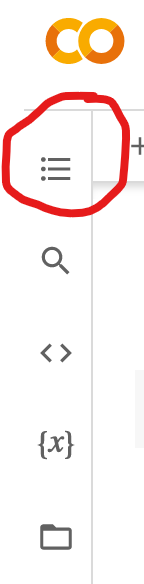

Now click the **Files** icon, then **Upload to session storage**, as shown.

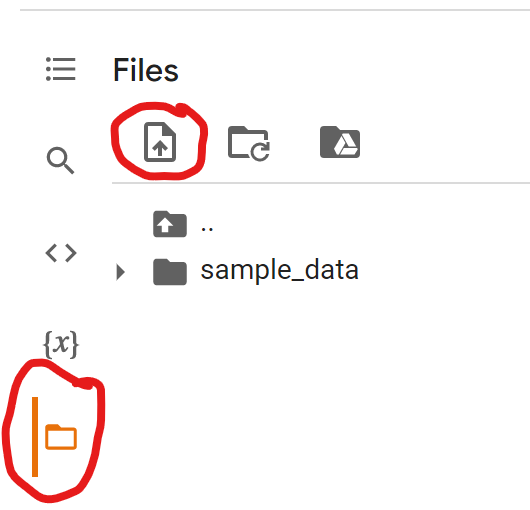

Read your CSV file in to a DataFrame:

In [ ]:
df = pd.read_csv("float_numbers.csv")

Get some information about your DataFrame:

In [ ]:
df.info

<bound method DataFrame.info of    size  cost  weight
0   4.0   7.0     9.0
1   6.0   8.0     3.0
2   5.0  10.0     7.0>

Check the data type:

In [ ]:
df.dtypes

size      int64
cost      int64
weight    int64
dtype: object

You'll see that it is of type `int`. Using what you've learned, convert it to type `float`.

In [ ]:
df = df.astype('float64')

Again, check the data type:

In [ ]:
df.dtypes

size      float64
cost      float64
weight    float64
dtype: object

Success! Now you know how to read in a local file, and also how to convert data types!

Next, you'll learn how to import a dataset from your Google Drive.

## Importing a dataset from a Google Drive

You just saw how to load a dataset from your local machine. But in the event that you don't have access to your local machine, there's a better way to do this so that you can access your dataset from the cloud using your Google Drive. You'll start by going to your Google account and then uploading your dataset to your Google Drive.

Once your dataset is in your Google Drive, you need to tell Colab to connect to your Google Drive. That process is called *mounting*. In Colab, mounting a drive starts with running the following code:

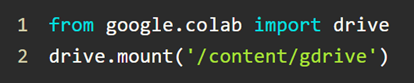

When you run this code, you will be prompted to click a URL and enter an authorization code into Colab.

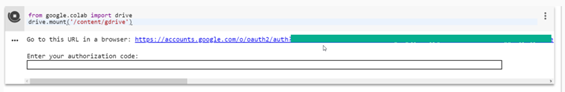

Then, you'll be prompted to authorize access from Google Drive File Stream into your account.

Click **Allow**, and then copy and paste your authorization code into Colab. You'll get a message that your drive has been mounted.

Now, try this out yourself. Upload the `item_cost.csv` file to My Drive in your Google Drive, and then mount Colab to your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import pandas and read in the GDrive-mounted CSV

# Import pandas if needed
import pandas as pd
    
df = pd.read_csv('/content/gdrive/My Drive/item_cost.csv')
df.head()

,item,cost
0,book,$50
1,magazine,$47
2,coffee,$25
3,labels,$15
4,music,$79


Perfect! But now you need to strip off the dollar sign symbol `$` from each of the prices so that you are working with numbers. There are multiple ways to do this; here, use the `replace()` method to replace the `$` with nothing. Then convert it to an integer, as you did before.

In [ ]:
df['cost'] = df['cost'].str.replace('$', '')
df['cost'] = df['cost'].astype(int)

In [ ]:
df.head()

,item,cost
0,book,50
1,magazine,47
2,coffee,25
3,labels,15
4,music,79


That's what you want! You'll encounter this in future lessons, so now you're ready!